# Markov Decision Process: Exact policy iteration implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mdp import MDP
from mdp import has_graphviz
from IPython.display import display

print("Graphviz available:", has_graphviz)

Graphviz available: True


In [2]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values

#### Setup the state/action transition probability and reward mappings

In [3]:
transition_probabilities = {
    's0': {   # [1,0,1,0]
        'a0': {'s0': 0.9, 's1': 0.1},
        'a1': {'s0': 1.0},
        'a2': {'s0': 0.9, 's7': 0.1},
    },
    's1': {   # [0,-1,1,0]
        'a0': {'s1': 0.9, 's4': 0.1},
        'a1': {'s1': 0.9, 's2': 0.1},
        'a2': {'s1': 0.9, 's3': 0.1},
    },
    's2': {   # [0,-1,0,-1]
        'a0': {'s2': 0.9, 's3': 0.1},
        'a1': {'s2': 0.9, 's1': 0.1},
        'a2': {'s2': 0.9, 's4': 0.1},
    },
    's3': {   # [1,0,0,-1]
        'a0': {'s3': 0.9, 's1': 0.1},
        'a1': {'s3': 0.9, 's0': 0.1},
        'a2': {'s3': 0.9, 's7': 0.1},
    },
    's4': {   # [-1,0,0,-1]
        'a0': {'s4': 0.9, 's10': 0.1},
        'a1': {'s4': 0.9, 's6': 0.1},
        'a2': {'s4': 0.9, 's5': 0.1},
    },
    's5': {   # [0,-1,-1,0]
        'a0': {'s5': 0.9, 's4': 0.1},
        'a1': {'s5': 0.9, 's2': 0.1},
        'a2': {'s5': 0.9, 's3': 0.1},
    },
    's6': {   # [-1,0,-1,0]
        # goal, finished
        'a1': {'s6': 1.0},
    },
    's7': {   # [0,1,1,0]
        'a0': {'s7': 0.9, 's11': 0.1},
        'a1': {'s7': 0.9, 's8': 0.1},
        'a2': {'s7': 0.9, 's9': 0.1},
    },
    's8': {   # [0,1,0,1]
        'a0': {'s8': 0.9, 's11': 0.1},
        'a1': {'s8': 0.9, 's7': 0.1},
        'a2': {'s8': 0.9, 's9': 0.1},
    },
    's9': {   # [-1,0,0,1]
        'a0': {'s9': 0.9, 's10': 0.1},
        'a1': {'s9': 0.9, 's6': 0.1},
        'a2': {'s9': 0.9, 's5': 0.1},
    },
    's10': {  # [0,1,-1,0]
        'a0': {'s10': 0.9, 's11': 0.1},
        'a1': {'s10': 0.9, 's8': 0.1},
        'a2': {'s10': 0.9, 's9': 0.1},
    },
    's11': {  # [1,0,0,1]
        'a0': {'s11': 0.9, 's1': 0.1},
        'a1': {'s11': 0.9, 's0': 0.1},
        'a2': {'s11': 0.9, 's7': 0.1},
    }
}

# goal: +5, default: -1
rewards = {}

# at first initialialise all possible transitions to -1
for state in transition_probabilities.keys():
    rewards[state] = {}
    for action in transition_probabilities[state].keys():
        rewards[state][action] = {}
        for newstate in transition_probabilities[state][action].keys():
            rewards[state][action][newstate] = -1

# then overwrite any non-default reward values - i.e.
# +5 for reaching the goal & no change for staying there
rewards['s4']['a1']['s6'] = 5
rewards['s6']['a1']['s6'] = 0
rewards['s9']['a1']['s6'] = 5

In [4]:
initial_state = 's0'
mdp = MDP(transition_probabilities, rewards, initial_state=initial_state)

#### Create an initial graph showing state transitions and probabilities
(using top-to-bottom orientation - i.e. portrait, not landscape - for the written report)

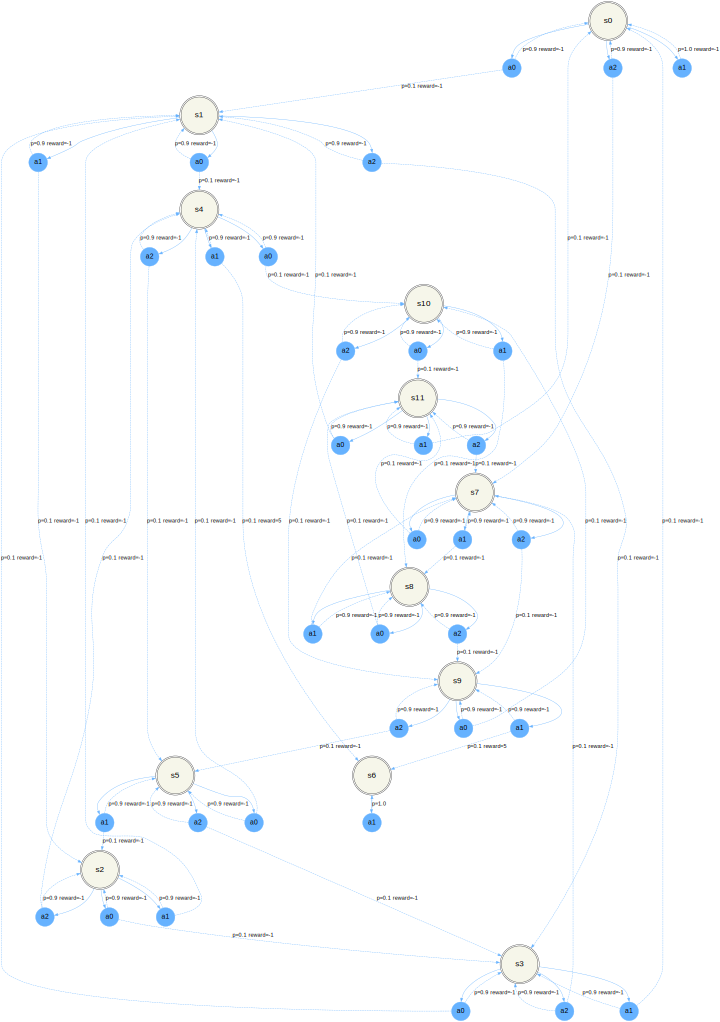

In [5]:
if has_graphviz:
    g = plot_graph(mdp, graph_size='10,25', s_node_size='1.5,5', rankdir='TB')  # top-to-bottom
    display(g)
    g.format = 'svg'
    g.render(directory='output', ).replace('\\', '/')

## **Value Iteration**

Start off by verifying the environment using the simpler algorithm - **V**alue **I**teration

Here's the pseudo-code for **VI**:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

First, we write a function to compute the state-action value function $Q({\pi})$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$

Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.

 $$V_{i+1}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

Now let's use those $V_{i+1}(s)$ to find optimal actions in each state

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
The only difference vs $V(s)$ is that here we take not max but argmax: find action such with maximum $Q(s,a)$.

#### Define a function that will return the action Q-value.
Note this function will also be used during the second phase in policy iteration later.

In [6]:
def get_action_value(mdp, state_values, state, action, gamma):
    Q = 0
    for s in mdp.get_all_states():
        Q = Q + mdp.get_transition_prob(state, action, s) * \
                        (mdp.get_reward(state, action, s) + \
                                 gamma * state_values[s]) 
    return Q

#### Computes next $V(s)$ as in formula above.

In [7]:
def get_new_state_value(mdp, state_values, state, gamma):
    if mdp.is_terminal(state):
        return None

    # Initialise the dict
    A = [a for a in mdp.get_possible_actions(state)]
    v = np.zeros(len(mdp.get_possible_actions(state)))
    i = 0

    # Compute all possible options
    for a in mdp.get_possible_actions(state):
        v[i] = get_action_value(mdp, state_values, state, a, gamma)
        A[i] = a
        i = i+1

    # Recover V(s) and π∗(s) as per the formula above
    V = {A[np.argmax(v)]:v[np.argmax(v)]}

    return V

#### Run the Value-Iteration algorithm

In [8]:
# parameters
gamma = 0.9            # discount for MDP
num_iterations = 1000   # maximum, excludes initialization

# stop if new values are this close (or closer) to old values
min_difference = 0.000001

# initialize V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

count = 0
for i in range(num_iterations):
    count = count + 1

    # Compute new state values using the functions defined above.
    # It must be a dict {state : float V_new(state)}
    new_state_values = {}
    for s in mdp.get_all_states():
        nsv = get_new_state_value(mdp, state_values, s, gamma)
        a = list(nsv)[0]
        v = nsv[a]
        new_state_values[s] = v

    # Compute change (delta) from this iteration
    difference = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
    print("iter %4i   |   diff: %7.6f   |   " % (i, difference), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if difference < min_difference:
        print("Converged")
        break

iter    0   |   diff: 1.000000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000   V(s3) = 0.000   V(s4) = 0.000   V(s5) = 0.000   V(s6) = 0.000   V(s7) = 0.000   V(s8) = 0.000   V(s9) = 0.000   V(s10) = 0.000   V(s11) = 0.000
iter    1   |   diff: 0.900000   |   V(s0) = -1.000   V(s1) = -1.000   V(s2) = -1.000   V(s3) = -1.000   V(s4) = -0.400   V(s5) = -1.000   V(s6) = 0.000   V(s7) = -1.000   V(s8) = -1.000   V(s9) = -0.400   V(s10) = -1.000   V(s11) = -1.000
iter    2   |   diff: 0.805140   |   V(s0) = -1.900   V(s1) = -1.846   V(s2) = -1.846   V(s3) = -1.900   V(s4) = -0.724   V(s5) = -1.846   V(s6) = 0.000   V(s7) = -1.846   V(s8) = -1.846   V(s9) = -0.724   V(s10) = -1.846   V(s11) = -1.900
iter    3   |   diff: 0.716461   |   V(s0) = -2.705   V(s1) = -2.560   V(s2) = -2.560   V(s3) = -2.705   V(s4) = -0.986   V(s5) = -2.560   V(s6) = 0.000   V(s7) = -2.560   V(s8) = -2.560   V(s9) = -0.986   V(s10) = -2.560   V(s11) = -2.705
iter    4   |   diff: 0.634541   |   V(s0) = -3.422

#### Plot state graph with final values from Value Iteration

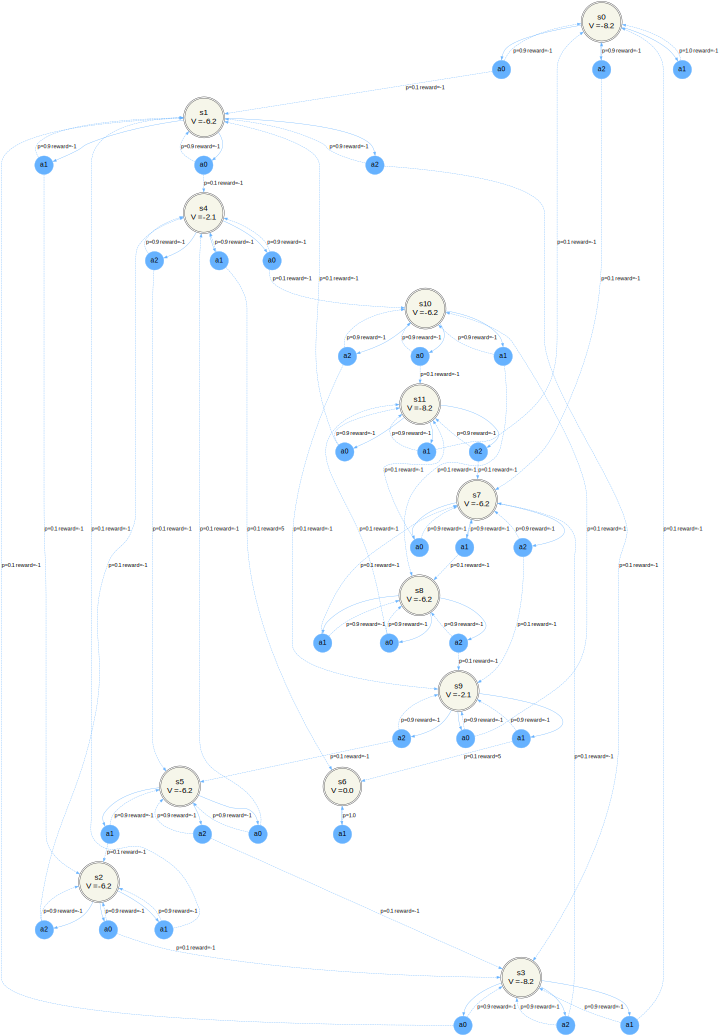

In [9]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

## **Policy Iteration**

Now implement the exact algorithm - **P**olicy **I**teration

Here's the pseudo-code for **PI**:

---

`1.` Initialize $V^{(0)}(s)=0$ and $\pi^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots max\_policy\_iterations$

`3. ` $\quad$**Policy Evaluation**

$\quad\quad\quad$For $j=0, 1, 2, \dots max\_value\_iterations$

$\quad\quad\quad\quad$ $V_{(j+1)}(s) = \sum_{s'} P(s' | s,\pi (s)) \cdot [ r(s,\pi (s),s') + \gamma V_{j}(s')]$, for all $s$

`4. ` $\quad$**Policy Iteration**

$\quad\quad\quad$_policy-stable_ = _true_

$\quad\quad\quad\pi_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

$\quad\quad\quad$If $\pi_{(i)}(s) \ne \pi_{(i+1)}(s)$ then _policy-stable_ = _false_

$\quad\quad\quad$If _policy-stable_ then stop; else go to `3.`

---

First, compute the value for each state $Q({\pi (s)})$ in a similar way to **VI**

$$Q_i(s,\pi (s)) = \sum_{s'} P(s' | s,\pi (s)) \cdot [ r(s,\pi (s),s') + \gamma V_{i}(s')]$$

Using $Q(s,\pi (s))$ we can now define the "next" V(s), simply computing values using the current policy instead of maximizing over all actions

$$V_{i+1}(s) = \sum_{s'} P(s' | s,a) \cdot [ r(s,\pi (s),s') + \gamma V_{i}(s')] = Q_i(s,\pi (s))$$

Now we perform the policy improvement phase, where we iterative over all actions and find optimal policy for each state

$$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$

If there is still change in the policy during this stage (verifying whether the action suggested by the current policy is really the value-maximizing action), we take the updated policy back for further evaluation.

If there is no change in policy though (policy is stable), the algorithm is finished because the optimal policy has been found.

#### Define a function that will return the policy Q-value.

In [10]:
def get_policy_value(mdp, state_values, policy_values, state, gamma):
    Q = 0
    for s in mdp.get_all_states():
        a = policy_values[s]
        if a not in mdp.get_possible_actions(state):
            continue
        Q = Q + mdp.get_transition_prob(state, a, s) * \
                        (mdp.get_reward(state, a, s) + \
                                gamma * state_values[s]) 
    return Q

#### Define a function to help track policy reward as the algorithm progresses

In [11]:
num_reward_iterations = 1000

def get_policy_reward(mdp, policy_values):
    mdp.reset()
    total_reward = 0
    state = initial_state

    for i in range(num_reward_iterations):
        (state, reward, _, _) = mdp.step(policy_values[state])
        total_reward += reward

    return total_reward

#### Run the Policy-Iteration algorithm

In [12]:
# parameters
gamma = 0.9     # discount for MDP
num_value_iterations = 1000    # maximum, excludes initialization
num_policy_iterations = 1000   # maximum, excludes initialization

# error tolerance
min_difference = 0.05

# initialize V(s) and pi(s)
state_values = {s: 0 for s in mdp.get_all_states()}
policy_values = {s: 'a1' for s in mdp.get_all_states()}

# keep track of all rewards for graphing
rewards_list = [0 for i in range(num_policy_iterations)]
rewards_average = [0 for i in range(num_policy_iterations)]

count_policy = 0
for i in range(num_policy_iterations):
    count_policy = count_policy + 1
    optimal_policy = True

    # Policy evaluation
    count_value = 0
    for j in range(num_value_iterations):
        count_value = count_value + 1

        max_difference = 0
        for s in mdp.get_all_states():
            value = get_policy_value(mdp, state_values, policy_values, s, gamma)
            max_difference = max(max_difference, abs(value - state_values[s]))
            state_values[s] = value

            #print("v iter %4i  |   diff: %6.5f   |   " % (j, max_difference), end="")
            #print('   '.join("V(%s) = %.3f" % (k, v) for k, v in state_values.items()))

        # if maximum difference below threshold, finish this evaluation round
        if max_difference < min_difference:
            break

    # Policy iteration
    for s in mdp.get_all_states():

        max_value = state_values[s]
        for a in mdp.get_possible_actions(s):
            value = get_action_value(mdp, state_values, s, a, gamma)

            #print('state', s, '- value', value, 'vs', 'max_value', max_value, 'and action', policy_values[s], 'vs', a)

            # Update policy if it improves with a new action
            if value > max_value and policy_values[s] != a:
                optimal_policy = False
                policy_values[s] = a
                max_value = value

    rewards_list[i] = get_policy_reward(mdp, policy_values)
    rewards_average[i] = (sum(rewards_list) / count_policy)
    print("pi iter %4i |   rave: %6.5f   |   " % (i, rewards_average[i]), end="")
    print('   '.join("pi(%s) = %s" % (k, v) for k, v in policy_values.items()))

    if optimal_policy:
        print("Optimal policy found")
        break

print()
print("Policy:", policy_values)
print("Reward:", get_policy_reward(mdp, policy_values))

pi iter    0 |   rave: -1000.00000   |   pi(s0) = a1   pi(s1) = a0   pi(s2) = a2   pi(s3) = a1   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a1
pi iter    1 |   rave: -509.50000   |   pi(s0) = a0   pi(s1) = a0   pi(s2) = a2   pi(s3) = a0   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a0
pi iter    2 |   rave: -342.33333   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter    3 |   rave: -260.75000   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter    4 |   rave: -211.80000   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   p

pi iter   56 |   rave: -41.05263   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter   57 |   rave: -40.72414   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter   58 |   rave: -40.45763   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter   59 |   rave: -40.25000   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter   60 |   rave: -40.49180   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  118 |   rave: -31.77311   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  119 |   rave: -31.74167   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  120 |   rave: -31.71901   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  121 |   rave: -31.45902   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  122 |   rave: -31.43902   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  160 |   rave: -29.83851   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  161 |   rave: -29.96914   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  162 |   rave: -29.88957   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  163 |   rave: -29.73780   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  164 |   rave: -29.81212   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  204 |   rave: -28.57561   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  205 |   rave: -28.57282   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  206 |   rave: -28.49275   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  207 |   rave: -28.40385   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  208 |   rave: -28.40670   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  250 |   rave: -28.08367   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  251 |   rave: -28.13492   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  252 |   rave: -28.28854   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  253 |   rave: -28.20079   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  254 |   rave: -28.14118   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  307 |   rave: -26.96104   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  308 |   rave: -26.98058   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  309 |   rave: -26.96774   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  310 |   rave: -27.02251   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  311 |   rave: -27.00321   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  363 |   rave: -26.66209   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  364 |   rave: -26.64658   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  365 |   rave: -26.68033   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  366 |   rave: -26.71662   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  367 |   rave: -26.67391   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  423 |   rave: -26.25943   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  424 |   rave: -26.25647   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  425 |   rave: -26.23239   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  426 |   rave: -26.22482   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  427 |   rave: -26.21028   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  464 |   rave: -25.96774   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  465 |   rave: -26.05365   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  466 |   rave: -26.07495   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  467 |   rave: -26.08547   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  468 |   rave: -26.04264   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  526 |   rave: -25.83302   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  527 |   rave: -25.80303   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  528 |   rave: -25.78639   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  529 |   rave: -25.80000   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  530 |   rave: -25.79096   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  566 |   rave: -25.66843   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  567 |   rave: -25.65669   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  568 |   rave: -25.63445   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  569 |   rave: -25.63333   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  570 |   rave: -25.60595   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  606 |   rave: -25.72158   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  607 |   rave: -25.72533   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  608 |   rave: -25.71264   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  609 |   rave: -25.71639   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  610 |   rave: -25.71686   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  662 |   rave: -25.61689   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  663 |   rave: -25.60542   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  664 |   rave: -25.58346   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  665 |   rave: -25.57207   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  666 |   rave: -25.56522   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  723 |   rave: -25.75000   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  724 |   rave: -25.77241   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  725 |   rave: -25.79201   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  726 |   rave: -25.81018   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  727 |   rave: -25.82143   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  779 |   rave: -25.95769   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  780 |   rave: -25.93598   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  781 |   rave: -25.91176   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  782 |   rave: -25.91699   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  783 |   rave: -25.89158   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  836 |   rave: -25.72401   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  837 |   rave: -25.70644   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  838 |   rave: -25.68892   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  839 |   rave: -25.66548   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  840 |   rave: -25.67063   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  891 |   rave: -25.48767   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  892 |   rave: -25.48376   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  893 |   rave: -25.51566   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  894 |   rave: -25.49832   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  895 |   rave: -25.51116   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

pi iter  947 |   rave: -25.31118   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  948 |   rave: -25.31296   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  949 |   rave: -25.28526   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  950 |   rave: -25.27971   |   pi(s0) = a2   pi(s1) = a0   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a0   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) = a1   pi(s10) = a2   pi(s11) = a2
pi iter  951 |   rave: -25.26155   |   pi(s0) = a2   pi(s1) = a1   pi(s2) = a2   pi(s3) = a2   pi(s4) = a1   pi(s5) = a1   pi(s6) = a1   pi(s7) = a2   pi(s8) = a2   pi(s9) 

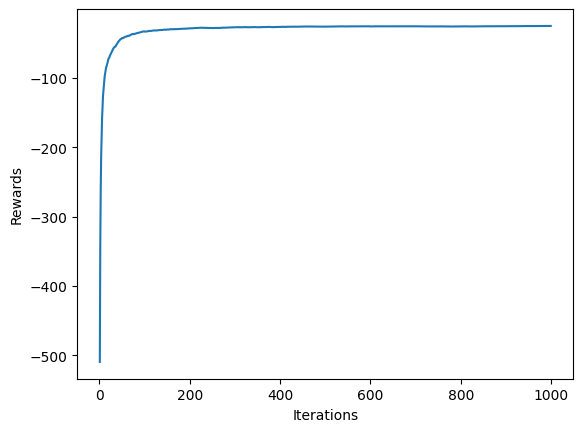

In [13]:
iterations = [i for i in range(num_policy_iterations)]
plt.ylabel('Rewards')
plt.xlabel('Iterations')
plt.plot(iterations[1:], rewards_average[1:])
plt.show()

#### Plot state graph with final values from Policy Iteration

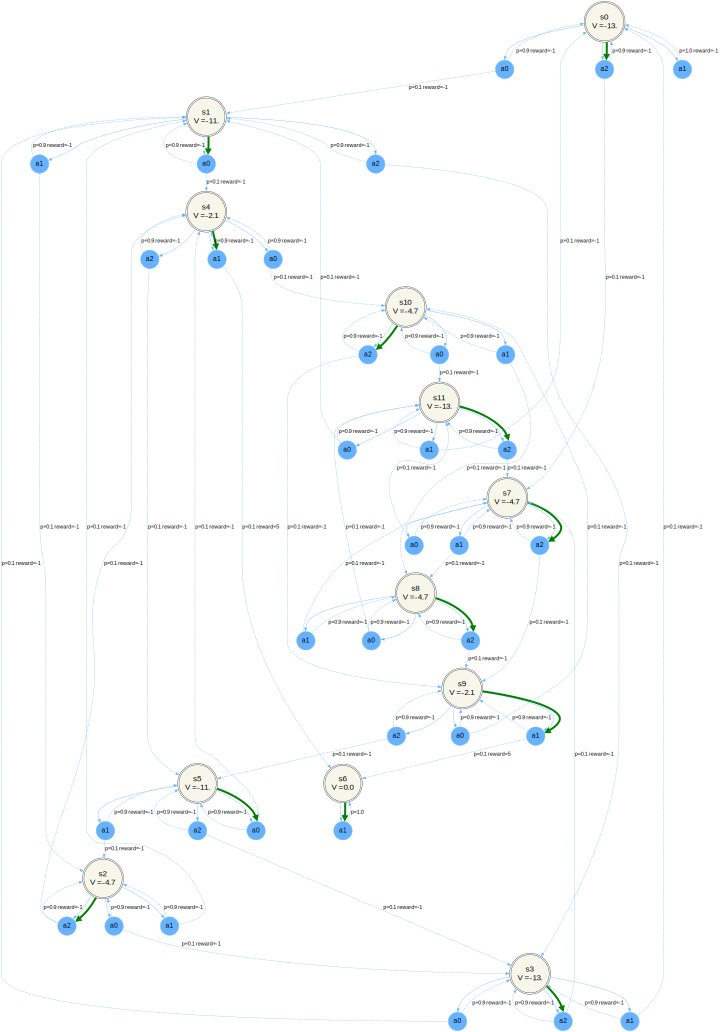

In [14]:
if has_graphviz:
    g = plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value)
    display(g)
    g.format = 'svg'
    g.render(directory='output', ).replace('\\', '/')